# Table of contents

1. [Introduction](#intro)
2. [Import dependencies](#import_dep)
3. [Feature engineering](#feature_eng)
4. [Evaluating model performance](#eval_metrics)
5. [Generating the models](#gen_models)

# 1. Introduction
<a class="anchor" id="intro"></a>

These sets of notebooks introduce document classifier that's able to successfully identify articles that contain drug-target interaction information and those that do not. In the previous notebook, we explored our document dataset. In this notebook, we engineer our features, define our evaluation metrics, and begin building our models.

# 2. Import dependencies
<a class="anchor" id="import_dep"></a>

In [1]:
# Base packages
import os
import string
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
import matplotlib.pyplot as plt
from google.cloud import bigquery

# Natural Language Toolkit (NLTK) packages
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Scikit-learn packages
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Define relative paths
NOTEBOOKS = os.getcwd()
ROOT = NOTEBOOKS.replace('Document_clf/Notebooks', '')
WKDIR = NOTEBOOKS.replace('/Notebooks', '')
INPUT = WKDIR + '/Input'
DATA = WKDIR + '/Data'

# 3. Feature engineering
<a class="anchor" id="feature_eng"></a>

Four of the most common unigrams that appear in positively labeled articles are "inhibitors," "inhibition," "inhibitory," "inhibitor." These words, although distinct, have similar enough meanings that they can essentially be treated as a single feature. This introduces the notion of term lemmatization, which refers to the process of removing inflectional endings from a word and returning it to its "dictionary" form.

Term lemmatization is one of several text pre-processing operations that we can use to reduce the number of duplicative or superfluous features in our dataset. For now, let's stick with the following operations:

- **Normalize case and remove punctuation**
    - The vectorizing operation is case-sensitive. Therefore, we will convert all character to lowercase. In addition, we remove punctuation characters from the string, because these characters are unlikely to add significant predictive power.
    
- **Remove short terms**
    - We define "short" terms to be terms with fewer than four characters. Removing short terms reduces the total number of features in our final dataset and also removes words with little predictive power (one-letter characters, articles, pronouns, etc.)
- **Lemmatize terms**
    - As described above, lemmatization refers to the process of removing inflectional ends from a word and returning it to its "dictionary" form
    - For example, the lemmatized form of "am," "are," and "is" $\Rightarrow$ "be"
    - By removing inflectional endings, lemmatization reduces the number of unique forms of a given base word, thereby reducing the total number of features in the final dataset.
    
Let's define some helper functions to carry out these pre-processing operations.

In [2]:
def case_punct_normalizer(string, punctuation=string.punctuation):
    """Remove all punctuation and convert all characters to lowercase.

    Keyword arguments:
    string      -- the string to be processed
    punctuation -- the concatenated string of punctuation characters to remove
    """
    processed = ""
    for char in string:
        if char not in punctuation:
            processed = processed + char.lower()
    return processed


def short_term_remover(string, min_term_length, exceptions=[]):
    """Remove all words shorter than a threshold length

    Keyword arguments:
    string          -- the string to be processed
    min_term_length -- the threshold describing the minimum term length to keep
    exceptions      -- list of words less than the min_term_length to keep
    """
    processed = ""
    for word in string.split():
        if pd.Series(word in exceptions).any() or len(word) >= min_term_length:
            if len(processed)==0:
                processed = word
            else:
                processed = " ".join([processed, word])
    return processed


def term_lemmatizer(string, lemmatizer):
    """Lemmatize words

    Keyword arguments:
    string     -- the string to be processed
    lemmatizer -- an instantiated lemmatizer object (with a .lemmatize() function)
    """
    processed = ""
    for word in string.split():
        if len(processed)==0:
            processed = lemmatizer.lemmatize(word)
        else:
            processed = " ".join([processed, lemmatizer.lemmatize(word)])
    return processed

We can then package these pre-processing operations in custom transformers.

In [3]:
class VariableSelector(BaseEstimator, TransformerMixin):
    def __init__(self, var_list):
        self.var_list = var_list

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        combined = X[self.var_list].apply(lambda x: ' '.join(x), axis=1)
        return combined


class StringPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, min_term_length, exclusions, punctuation=string.punctuation):
        self.min_term_length = min_term_length
        self.exclusions = exclusions

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Normalize the case and remove extraneous punctuation.
        processed = X.apply(case_punct_normalizer)

        # Remove short terms
        processed = processed.apply(lambda x: short_term_remover(x, self.min_term_length, self.exclusions))

        # Lemmatize the remaining words.
        lm = WordNetLemmatizer()
        processed = processed.apply(lambda x: term_lemmatizer(x, lm))
        return processed


We can further package these transformers into different processing pipelines.

Above, we noted that we can vectorize bigrams according to their counts or the term-frequency inverse-document frequency (or, tf-idf). Although the former is pretty self-explanatory, the latter requires a bit of clarification. Rather than using raw counts, a tf-idf vectorizer attempts to summarize how important a word is in a given corpus. The tf-idf statistic is calculated by multiplying two statistics together: *term frequency* and *inverse document frequency*. The former is simply the raw count of the term in the corpus. The latter is calculated by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient. Intuitively, as the term appears in more documents, the quotient approaches 1, bringing the idf (and therefore, the tf-idf), closer to 0. In this way, the tf-idf gives higher weights to more uncommon (i.e., potentially more important) terms. It's always a good idea to normalize one's features, so let's stick with the TF-IDF vectorizer for now.

In [4]:
# Vectorize unigrams
unigram_tfidf = Pipeline([
    ('selector', VariableSelector(var_list=['abstract'])),
    ('pre-processor', StringPreprocessor(min_term_length=4, exclusions=[])),
    ('vectorizer', CountVectorizer(token_pattern='(?u)\\b\\w\\w+\\b', stop_words='english', ngram_range=(1, 1)))
])

# Vectorize bigrams
bigram_tfidf = Pipeline([
    ('selector', VariableSelector(var_list=['abstract'])),
    ('pre-processor', StringPreprocessor(min_term_length=4, exclusions=[])),
    ('vectorizer', CountVectorizer(token_pattern='(?u)\\b\\w\\w+\\b', stop_words='english', ngram_range=(2, 2)))
])

# 4. Evaluating model performance
<a class="anchor" id="eval_metrics"></a>

There are three common metrics used to evaluate the performance for binary classifiers: sensitivity, specificity, and the Matthews Correlation Coefficient (MCC). The "sensitivity" of the model quantifies the proportion of actual positives that are correctly identified as such. Conversely, the "specificity" of the model quantifies the proportion of actual negatives that are correctly identified as such. The MCC metric takes into account both true and false positives and negatives to summarize the association between the target variable and the predictions. Let's define functions to calculate these metrics.

In [5]:
def calculate_sensitivity(y_true, y_preds):
    """Calculate the sensitivity of the model.

    Keyword arguments:
    y_true  -- list of the true labels for the test data
    y_preds -- list of the predicted labels for the test data
    """
    try:
        len(y_true) == len(y_preds)
    except ValueError:
        print("Labels and predictions not the same size")

    # Calculate the number of true positives, false negatives, and the resulting sensitivity
    tp = np.sum([y_true[i] == 1 and y_preds[i] == 1 for i in range(0, len(y_true))])
    fn = np.sum([y_true[i] == 1 and y_preds[i] == 0 for i in range(0, len(y_true))])
    sensitivity = tp / (tp + fn)
    return sensitivity


def calculate_specificity(y_true, y_preds):
    """Calculate the specificity of the model

    Keyword arguments:
    y_true  -- list of the true labels for the test data
    y_preds -- list of the predicted labels for the test data
    """
    try:
        len(y_true) == len(y_preds)
    except ValueError:
        print("Labels and predictions not the same size")

    # Calculate the number of true positives, false negatives, and the resulting sensitivity
    tn = np.sum([y_true[i] == 0 and y_preds[i] == 0 for i in range(0, len(y_true))])
    fp = np.sum([y_true[i] == 0 and y_preds[i] == 1 for i in range(0, len(y_true))])
    specificity = tn / (tn + fp)
    return specificity


def calculate_MCC(y_true, y_preds):
    """Calculate the Matthews Correlation Coefficient of the model

    Keyword arguments:
    y_true  -- list of the true labels for the test data
    y_preds -- list of the predicted labels for the test data
    """
    try:
        len(y_true) == len(y_preds)
    except ValueError:
        print("Labels and predictions not the same size")
    tp = np.sum([y_true[i] == 1 and y_preds[i] == 1 for i in range(0, len(y_true))])
    fn = np.sum([y_true[i] == 1 and y_preds[i] == 0 for i in range(0, len(y_true))])
    tn = np.sum([y_true[i] == 0 and y_preds[i] == 0 for i in range(0, len(y_true))])
    fp = np.sum([y_true[i] == 0 and y_preds[i] == 1 for i in range(0, len(y_true))])
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    return mcc

def calculate_eval_scores(y_true, y_preds):
    """Generate a dataframe with the evaluation scores
    
    Keyword arguments:
    y_true  -- list of the true labels for the test data
    y_preds -- list of the predicted labels for the test data
    """
    # Generate a map to be converted into a dataframe
    performance_measures = {'accuracy': [],
                            'sensitivity': [],
                            'specificity': [],
                            'mcc': []}
    
    # Calculate the statistics
    performance_measures['accuracy'].append(np.mean(y_true==y_preds))
    performance_measures['sensitivity'].append(calculate_sensitivity(y_true.to_list(), list(y_preds)))
    performance_measures['specificity'].append(calculate_specificity(y_true.to_list(), list(y_preds)))
    performance_measures['mcc'].append(calculate_MCC(y_true.to_list(), list(y_preds)))
    
    # Transpose
    performance_measures = pd.DataFrame(performance_measures)
    performance_measures = performance_measures.transpose()
    return performance_measures

In addition to using the metrics we defined above, we'll also generate the ROC curve for our model. The ROC curve plots the true positive rate (i.e., the signal) against the false positive rate (i.e., the noise) at various thresholds or decision points, and is often used to assess the quality of a binary classifier model. Let's define a function to plot this ROC curve.

In [6]:
def plot_roc(trained_model, X_test, y_test):
    """Plot the ROC curve and the mean ROC curve.

    Keyword arguments:
    trained_model -- the trained classifier model
    X_test        -- the test data
    y_test        -- the test data's labels
    """
    
    # There are two common functions used to generate the scores necessary to produce an ROC curve: 'decision_function,'
    # or 'predict_proba.' The 'decision_function' method directly produced a score for each classifier. The
    # 'predict_proba' method calculates the probability that a given observation will fall in either class. The ROC
    # curve requires scores, not probabilities. Therefore, we will use the former method if the classifier supports it;
    # if not, then we will use the positive class's probability as a proxy for the scores.
    if hasattr(trained_model, "decision_function"):
        scores = trained_model.decision_function(X_test)
    else:
        scores = trained_model.predict_proba(X_test)[:, 1]
    
    # Calculate the false positive rate and true positive rate under various thresholds, and the AUC
    fpr, tpr, thresholds = roc_curve(y_test, scores)
    model_auc = auc(fpr, tpr)
    
    # Plot
    plt.plot(fpr, tpr, lw=2, label="AUC = %0.2f" % model_auc)
  
    # Plot the curve associated with a classifier that randomly predicts the labels
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    # Specify axis limits and titles, and display plot
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# 5. Generating the models
<a class="anchor" id="gen_models"></a>

Let's create our training and testing dataset.

In [7]:
# First, let's load our analysis dataset
data = pd.read_csv(DATA + '/ChEMBL document data (all, 6k).csv',)

features = ['abstract', 'title']
target = 'target'
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.33, random_state=42)

We will create three different models: 1) a Naive Bayes classifier, 2) a Logistic Regression classifier, and 3) a Random Forest classifier. Let's first vectorize the training and testing data.

In [8]:
# Vectorize the training and testing data into unigrams
unigram_train = unigram_tfidf.fit_transform(X_train)
unigram_test = unigram_tfidf.transform(X_test)

# Vectorize the training and testing data into unigrams
bigram_train = bigram_tfidf.fit_transform(X_train)
bigram_test = bigram_tfidf.transform(X_test)

When the number of features is greater than the number of data points, the problem of finding the best model is said to be *underdetermined*. We can address this issue by introducing regularization constraints on the training process. Specifically, we can introduce these constraints when training our LogisticRegression and RandomForest classifiers.

The regularization parameters cannot be "learned" from the data; rather, they need to be manually tuned to the problem at hand. We can tune these parameters using k-fold cross validation. This procedure involves defining different validation sets and averaging the model performance across these sets as follows:

- Randomly split the training data into k folds, or subsets.
- For each unique fold:
    - Set that fold aside as the "validation" fold
    - Train the model using the remaining k-1 folds
    - Test the data on the "validation" fold
    - Calculate the model's evaluation metrics
- Summarize the skill of the model using the evaluation scores of the different folds

In [9]:
# Logistic Regression grid search for unigram features
lr_unigram_param_grid = {'C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}
lr_unigram_search = GridSearchCV(LogisticRegression(), cv=5, param_grid=lr_unigram_param_grid)
lr_unigram_search.fit(unigram_train, y_train)

# Logistic Regression grid search for bigram features
lr_bigram_param_grid = {'C': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]}
lr_bigram_search = GridSearchCV(LogisticRegression(), cv=5, param_grid=lr_bigram_param_grid)
lr_bigram_search.fit(bigram_train, y_train)

# Examine the best parameters
print("Optimal hyperparameter using unigram features: " + str(lr_unigram_search.best_params_['C']))
print("Optimal hyperparameter using bigram features: " + str(lr_bigram_search.best_params_['C']))

Optimal hyperparameter using unigram features: 0.1
Optimal hyperparameter using bigram features: 1.0


In [10]:
# Logistic Regression grid search for unigram features
rf_unigram_param_grid = {'max_depth': [10, 100, 250, 500, 1000]}
rf_unigram_search = GridSearchCV(RandomForestClassifier(), cv=5, param_grid=rf_unigram_param_grid)
rf_unigram_search.fit(unigram_train, y_train)

# Logistic Regression grid search for bigram features
rf_bigram_param_grid = {'max_depth': [10, 100, 250, 500, 1000]}
rf_bigram_search = GridSearchCV(RandomForestClassifier(), cv=5, param_grid=rf_bigram_param_grid)
rf_bigram_search.fit(bigram_train, y_train)

# Examine the best parameters
print("Optimal depth using unigram features: " + str(rf_unigram_search.best_params_['max_depth']))
print("Optimal depth using bigram features: " + str(rf_bigram_search.best_params_['max_depth']))

Optimal depth using unigram features: 250
Optimal depth using bigram features: 250


Now, let's generate the models and evaluate them using the statistics defined in the previous section.

In [11]:
def generate_models(model_list, X_train, y_train, X_test, y_test):
    """Generate the models and output a dataframe with the specificity, sensitivity, and MCC
    
    Keyword arguments:
    model_list -- the list of models to generate
    X_train    -- the vectorized training dataset
    y_train    -- the labels of the training dataset
    X_test     -- the vectorized test dataset
    y_test     -- the labels of the test dataset
    """
    models = {}
    model_eval = {}
    for m in model_list: 
        # Train the model and generate the evaluation statistics
        clf = clone(m)
        clf.fit(X_train, y_train)
        eval_scores = calculate_eval_scores(y_test, clf.predict(X_test))
        model_name = type(clf).__name__
        models[model_name] = clf
        model_eval[model_name] = eval_scores

    # Combine the results into a single dataframe
    keys = list(model_eval.keys())
    result = model_eval[keys[0]]
    for i in range(1,len(keys)):
        result = result.merge(model_eval[keys[i]], how='outer', left_index=True, right_index=True)
    result.columns = keys
    return (models, result)

In [12]:
unigram_model_list = [MultinomialNB(), LogisticRegression(C=lr_unigram_search.best_params_['C']), RandomForestClassifier(max_depth=rf_unigram_search.best_params_['max_depth'])]
unigram_models, unigram_evals = generate_models(unigram_model_list, unigram_train, y_train, unigram_test, y_test)
unigram_evals

,MultinomialNB,LogisticRegression,RandomForestClassifier
accuracy,0.802273,0.808081,0.764899
sensitivity,0.857072,0.802291,0.754980
specificity,0.745902,0.814037,0.775102
mcc,0.607279,0.616269,0.530072


In [13]:
bigram_model_list = [MultinomialNB(), LogisticRegression(C=lr_bigram_search.best_params_['C']), RandomForestClassifier(max_depth=rf_bigram_search.best_params_['max_depth'])]
bigram_models, bigram_evals = generate_models(bigram_model_list, bigram_train, y_train, bigram_test, y_test)
bigram_evals

,MultinomialNB,LogisticRegression,RandomForestClassifier
accuracy,0.801010,0.796970,0.750253
sensitivity,0.872012,0.780378,0.722112
specificity,0.727971,0.814037,0.779201
mcc,0.607026,0.594546,0.501890


The models generated using the unigram features seem to perform as well as their bigram counterparts. The Multinomial Naive Bayes and Logistic Regression classifiers consistently outperform the Random Forest classifiers. Let's view the ROC curves of the classifiers generated using the unigram features. The ROC curve plots the true positive rate (i.e., the signal) against the false positive rate (i.e., the noise) at various thresholds or decision points, and is often used to assess the quality of a binary classifier model. Let's define a function to plot this ROC curve.

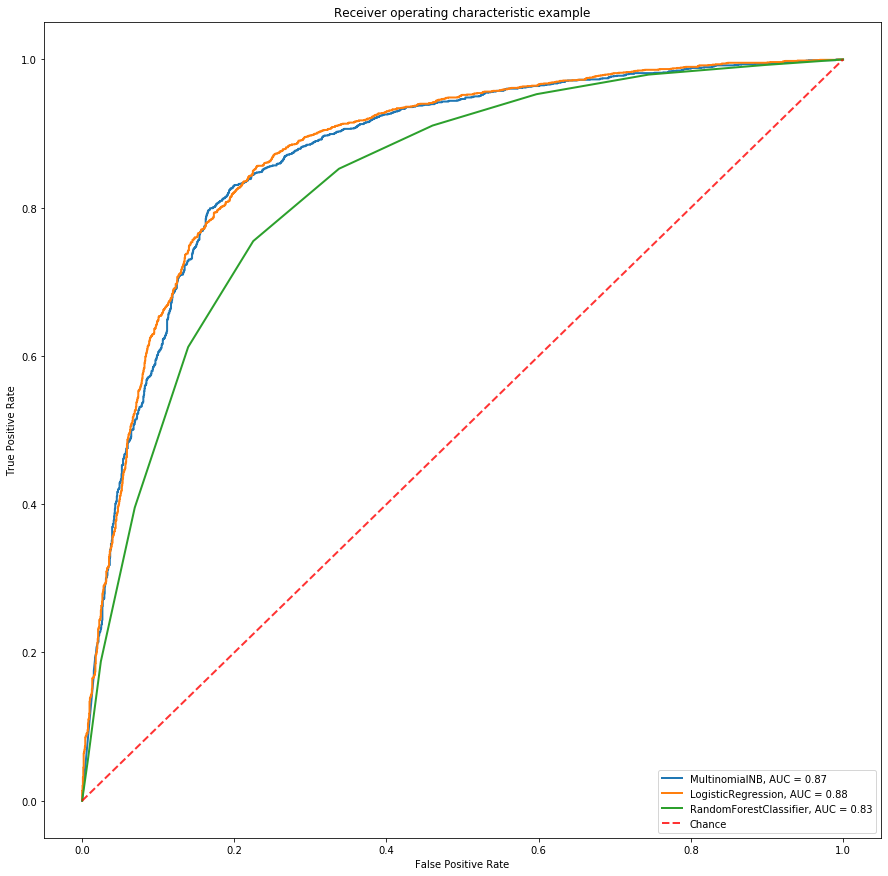

In [14]:
# Define the plot size
plt.rcParams["figure.figsize"] = (15,15)

def plot_roc(trained_models, X_test, y_test):
    """Plot the ROC curve and the mean ROC curve.

    Keyword arguments:
    trained_model -- the dictionary containing the trained classifiers
    X_test        -- the test data
    y_test        -- the test data's labels
    """
    
    for model in trained_models.keys():
        # There are two common functions used to generate the scores necessary to produce an ROC curve: 'decision_function,'
        # or 'predict_proba.' The 'decision_function' method directly produced a score for each classifier. The
        # 'predict_proba' method calculates the probability that a given observation will fall in either class. The ROC
        # curve requires scores, not probabilities. Therefore, we will use the former method if the classifier supports it;
        # if not, then we will use the positive class's probability as a proxy for the scores.
        if hasattr(trained_models[model], "decision_function"):
            scores = trained_models[model].decision_function(X_test)
        else:
            scores = trained_models[model].predict_proba(X_test)[:, 1]
        
        # Calculate the false positive rate and true positive rate under various thresholds, and the AUC
        fpr, tpr, thresholds = roc_curve(y_test, scores)
        model_auc = auc(fpr, tpr)

        # Plot
        plt.plot(fpr, tpr, lw=2, label="%s, AUC = %0.2f" % (model, model_auc))
  
    # Plot the curve associated with a classifier that randomly predicts the labels
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    # Specify axis limits and titles, and display plot
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# Plot the ROC for the classifiers generated using the unigram features    
plot_roc(unigram_models, unigram_test, y_test)